# **Определение перспективного тарифа для телеком компании**

### Описание проекта
Компания **«Мегалайн»** — федеральный оператора сотовой связи. Предлагает клиентам  два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Нужно сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей **«Мегалайна»**: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Тариф «Смарт»**
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
  * минута разговора: 3 рубля
  * сообщение: 3 рубля
  * 1 Гб интернет-трафика: 200 рублей
  
**Тариф «Ультра»**
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
   * минута разговора: 1 рубль
   * сообщение: 1 рубль
   * 1 Гб интернет-трафика: 150 рублей
   
**<font color="red"> <b>«Мегалайн»</b>
    всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.</font>**

### Описание данных
Таблица **users** (информация о пользователях):
- **user_id** — уникальный идентификатор пользователя
- **first_name** — имя пользователя
- **last_name** — фамилия пользователя
- **age** — возраст пользователя (годы)
- **reg_date** — дата подключения тарифа (день, месяц, год)
- **churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- **city** — город проживания пользователя
- **tariff** — название тарифного плана
Таблица **calls** (информация о звонках):
- **id** — уникальный номер звонка
- **call_date** — дата звонка
- **duration** — длительность звонка в минутах
- **user_id** — идентификатор пользователя, сделавшего звонок
Таблица **messages** (информация о сообщениях):
- **id** — уникальный номер сообщения
- **message_date** — дата сообщения
- **user_id** — идентификатор пользователя, отправившего сообщение
Таблица **internet** (информация об интернет-сессиях):
- **id** — уникальный номер сессии
- **mb_used** — объём потраченного за сессию интернет-трафика (в мегабайтах)
- **session_date** — дата интернет-сессии
- **user_id** — идентификатор пользователя
Таблица **tariffs** (информация о тарифах):
- **tariff_name** — название тарифа
- **rub_monthly_fee** — ежемесячная абонентская плата в рублях
- **minutes_included** — количество минут разговора в месяц, включённых в абонентскую плату
- **messages_included** — количество сообщений в месяц, включённых в абонентскую плату
- **mb_per_month_included** — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- **rub_per_minute** — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- **rub_per_message** — стоимость отправки сообщения сверх тарифного пакета
- **rub_per_gb** — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Шаг 1. Откроем файл с данными и изучим общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats as st

**1.1. Загружаем данные**

In [2]:
df_calls = pd.read_csv('/datasets/calls.csv')
df_int = pd.read_csv('/datasets/internet.csv')
df_mess = pd.read_csv('/datasets/messages.csv')
df_tariff = pd.read_csv('/datasets/tariffs.csv')
df_users = pd.read_csv('/datasets/users.csv')

**1.2. Посмотрим на датасеты, информацию по ним и числовое описание данных.**

Для удобства создадим список датасетов user_list

In [3]:
user_list = [df_calls, df_int, df_mess, df_tariff, df_users]


names_df = ['Звонки', 'Интернет', 'Сообщения', 'Тарифы', 'Пользователи']
for i in range(len(user_list)):
    print('Посмотрим на данные файла -', names_df[i])        
    display(user_list[i].head(10))
    display(user_list[i].info())
    display(user_list[i].describe().T)

Посмотрим на данные файла - Звонки


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

,count,mean,std,min,25%,50%,75%,max
duration,202607.0,6.755887,5.843365,0.0,1.3,6.0,10.7,38.0
user_id,202607.0,1253.940619,144.722751,1000.0,1126.0,1260.0,1379.0,1499.0


Посмотрим на данные файла - Интернет


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,149396.0,74697.500000,43127.054745,0.0,37348.7500,74697.500,112046.2500,149395.00
mb_used,149396.0,370.192426,278.300951,0.0,138.1875,348.015,559.5525,1724.83
user_id,149396.0,1252.099842,144.050823,1000.0,1130.0000,1251.000,1380.0000,1499.00


Посмотрим на данные файла - Сообщения


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

,count,mean,std,min,25%,50%,75%,max
user_id,123036.0,1256.98941,143.523967,1000.0,1134.0,1271.0,1381.0,1499.0


Посмотрим на данные файла - Тарифы


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

,count,mean,std,min,25%,50%,75%,max
messages_included,2.0,525.0,671.751442,50.0,287.5,525.0,762.5,1000.0
mb_per_month_included,2.0,23040.0,10861.160159,15360.0,19200.0,23040.0,26880.0,30720.0
minutes_included,2.0,1750.0,1767.766953,500.0,1125.0,1750.0,2375.0,3000.0
rub_monthly_fee,2.0,1250.0,989.949494,550.0,900.0,1250.0,1600.0,1950.0
rub_per_gb,2.0,175.0,35.355339,150.0,162.5,175.0,187.5,200.0
rub_per_message,2.0,2.0,1.414214,1.0,1.5,2.0,2.5,3.0
rub_per_minute,2.0,2.0,1.414214,1.0,1.5,2.0,2.5,3.0


Посмотрим на данные файла - Пользователи


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

,count,mean,std,min,25%,50%,75%,max
user_id,500.0,1249.500,144.481833,1000.0,1124.75,1249.5,1374.25,1499.0
age,500.0,46.588,16.667630,18.0,32.00,46.0,62.00,75.0


***Вывод***
1. df_calls:
  * Пропусков нет.
  * Продолжительность разговора, в основном по 6 мин.
  * call_date - изменим тип на datetime.
  * Округлим значения минут в большую сторону. Потому что так поступает оператор.
2. df_int:
  * Пропусков нет.
  * Unnamed: 0 - Значения столбца копируют значения индексов. Можно удалить этот столбец, что бы не занимал место. Тем более что в описании про него ничего не сказано.
  * session_date - изменим тип на datetime.
  * Округлим значения трафика в большую сторону. Потому что так поступает оператор.
  * Объём потраченного за сессию интернет-трафика в среднем 370 mb
3. df_mess:
  * Пропусков нет.
  * message_date - изменим тип на datetime.
4. df_users:
  * Есть пропуски только в churn_date (дата прекращения пользования тарифом). Это означает что 38 человек ушли от оператора. Заменим NAN на 0 и изменим тип на datetime.
  * reg_date - изменим тип на datetime.

### Шаг 2. Предобработка данных
**2.1. Приведите данные к нужным типам**

Изменим тип данных в столбцах с датами во всех таблицах

In [4]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])
df_int['session_date'] = pd.to_datetime(df_int['session_date'])
df_mess['message_date'] = pd.to_datetime(df_mess['message_date'])
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'])
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'])

***Найдите и исправьте ошибки в данных***
Поясните, какие ошибки вы нашли и как их исправили. Обратите внимание, что длительность многих звонков — 0.0 минут. Это могут быть пропущенные звонки. Обрабатывать ли эти нулевые значения, решать вам — оцените, как их отсутствие повлияет на результаты анализа.

**2.2.Проверяем дубликаты**

In [5]:
for file in user_list:
    display(file.duplicated().sum())

0

0

0

0

0

Дубликатов по датасетам не обнаружено

**2.3. Датасет звонков df_calls**

Округлим данные по минутам и сделаме сводные таблица по кол-ву звонков и их прподолжительности

In [6]:
df_calls['duration'] = np.ceil(df_calls['duration']).astype(int)

In [7]:
df_calls.pivot_table(index=['duration'], values='user_id', aggfunc='count').sort_values('duration')

,user_id
duration,
0,39613
1,8402
2,9194
3,10362
4,10918
5,11411
6,11457
7,11510
8,11272


39613 звонков с длительностью 0 мин. Скорее всего это пропущеные звонки. Пропуски связаны, либос с прерыванием сигнала связи, либо у другого абонента было занято. Т.к. они не расходуют лимиты минут и не принимают участия в формировании конечной выручки, удаляем эти строки.

In [8]:
df_calls = df_calls[df_calls['duration'] > 0].reset_index()
df_calls = df_calls.drop(columns=['index'])

Проверим

In [9]:
df_calls[df_calls['duration'] == 0]

,id,call_date,duration,user_id


Нулевые значения длительности звонков удалены.

Построим гистограмму df_calls.

Text(0, 0.5, 'Кол-во звонков в год, шт.')

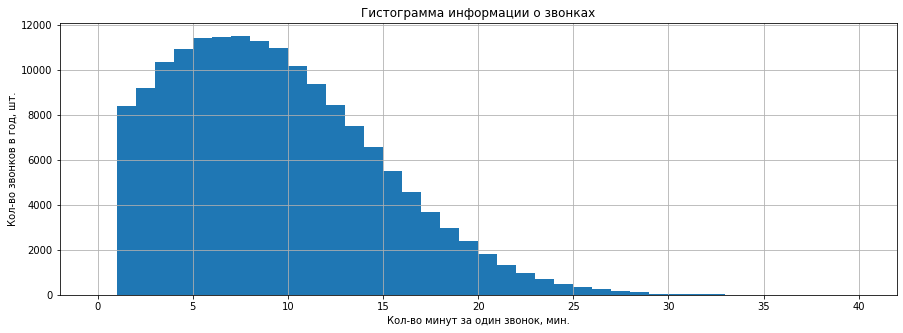

In [10]:
df_calls['duration'].plot(kind='hist', bins=40, range=(0, 40), title='Гистограмма информации о звонках',
                          figsize=(15,5), grid=True)
plt.xlabel('Кол-во минут за один звонок, мин.')
plt.ylabel('Кол-во звонков в год, шт.')

Гистограмма похожа на распределение Пуассона. Это означает что данные без вбросов

***2.4. Датасет интернет трафика df_int***

Округлим данные по трафику, в большую сторону, и сделаем сводные таблицы по кол-ву интернет сессий и их расходу Мб.

In [11]:
df_int['mb_used'] = np.ceil(df_int['mb_used']).astype(int)

Сортировка по кол-ву Мб за одну сессию.

In [12]:
df_int.pivot_table(index=['mb_used'], values='user_id', aggfunc='count').sort_values('mb_used')

,user_id
mb_used,
0,19598
1,102
2,98
3,96
4,100
...,...
1610,1
1624,1
1652,2


В 19598 сессий интернет-трафика потрачено 0 Мб. Это скорее всего связано с прерыванием сигнала связи или с подключением wi-fi.

Посмотрим на нулевые значения

In [13]:
df_int.query('mb_used == 0')

,Unnamed: 0,id,mb_used,session_date,user_id
11,11,1000_11,0,2018-08-28,1000
38,38,1000_38,0,2018-11-27,1000
46,46,1000_46,0,2018-06-30,1000
67,67,1000_67,0,2018-06-16,1000
72,72,1000_72,0,2018-06-15,1000
...,...,...,...,...,...
149380,149380,1499_141,0,2018-12-11,1499
149381,149381,1499_142,0,2018-11-01,1499
149383,149383,1499_144,0,2018-11-27,1499
149386,149386,1499_147,0,2018-10-21,1499


Удаляем столбец "Unnamed: 0" и нулевые значения из df_int потому что они не расходуют лимиты интернет трафика и не принимают участия в формировании конечной выручки. и столбец Unnamed: 0

In [14]:
df_int = df_int[df_int['mb_used'] > 0].reset_index()
df_int = df_int.drop(columns=['index', 'Unnamed: 0'])

Проверяем

In [15]:
df_int[df_int['mb_used'] == 0]

,id,mb_used,session_date,user_id


Построим гистограмму df_int.

Text(0, 0.5, 'Кол-во сессий в год, шт.')

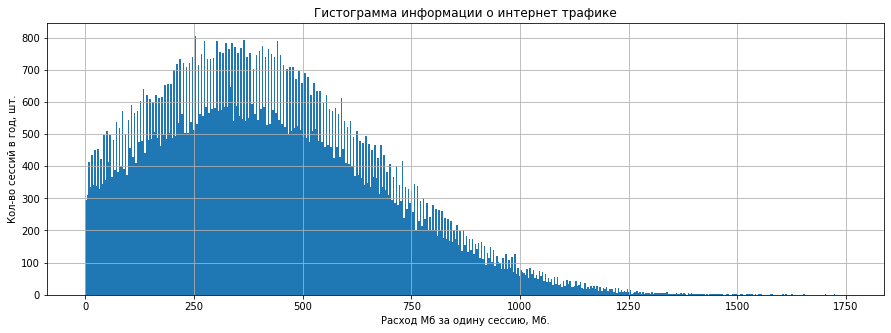

In [16]:
df_int['mb_used'].plot(kind='hist', bins=500, range=(0, 1750), title='Гистограмма информации о интернет трафике',
                          figsize=(15,5), grid=True)

plt.xlabel('Расход Мб за одину сессию, Мб.')
plt.ylabel('Кол-во сессий в год, шт.')

Гистограмма похожа на распределение Пуассона. Это означает что данные без вбросов

**2.5. Датасет СМС сообщений**

Посмотрим сколько СМС отправил каждый пользователь.

In [17]:
df_mess.pivot_table(index=['user_id'], values='id', aggfunc='count').sort_values('user_id')

,id
user_id,
1000,496
1002,70
1003,380
1004,1192
1005,552
...,...
1495,340
1496,468
1497,51


Посмотрим есть ли нулевые значения

In [18]:
df_mess.pivot_table(index=['user_id'], values='id', aggfunc='count').sort_values('id')

,id
user_id,
1141,1
1159,2
1074,3
1279,5
1111,6
...,...
1356,1224
1385,1380
1231,1384


Нулевых значений нет, но из 500 человек, СМС пользовались 426 чел. Скорее всего пользователи, которые не использовали СМС, не попали в этот датасет.

Построим Гистограмму

In [19]:
df_mess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


Text(0, 0.5, 'Кол-во пользователей')

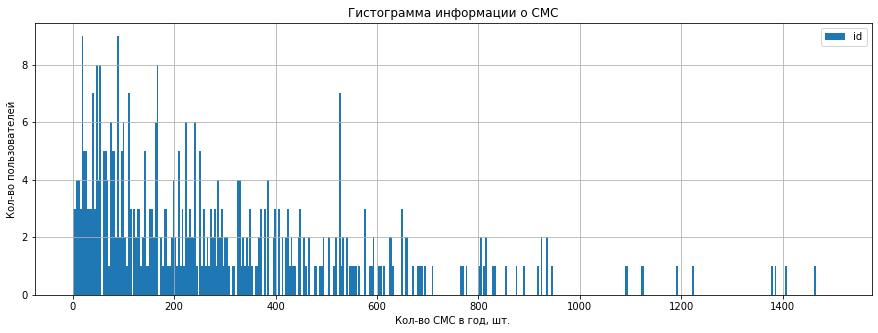

In [20]:
(df_mess.pivot_table(index=['user_id'], values='id', aggfunc='count')
        .plot(kind='hist', bins=426, range=(0, 1500), title='Гистограмма информации о СМС', figsize=(15,5), grid=True)
)

plt.xlabel('Кол-во СМС в год, шт.')
plt.ylabel('Кол-во пользователей')

In [21]:
df_mess.pivot_table(index=['user_id'], values='id', aggfunc='count').mean()

id    288.816901
dtype: float64

Среднее кол-во СМС в год - 288

**2.6. Датасет Пользователей df_users***

ПосмотримвВозрост пользователей

In [22]:
df_users.pivot_table(index=['age'], values='user_id', aggfunc='count')

,user_id
age,
18,6
19,9
20,9
21,12
22,5
23,9
24,9
25,7
26,11


In [23]:
df_users['age'].mean()

46.588

Средний возрасть пользователей 46 лет.

Построим гистограмму

Text(0, 0.5, 'Кол-во пользователей')

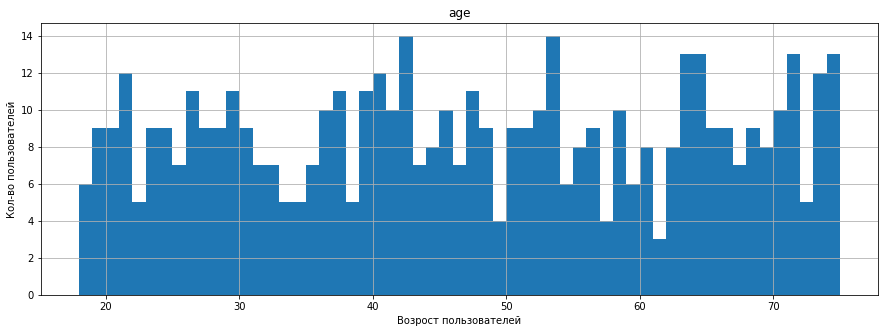

In [24]:
df_users.hist('age', bins=57, figsize=(15,5))
plt.xlabel('Возрост пользователей')
plt.ylabel('Кол-во пользователей')

**2.7. Посчитаем для каждого пользователя:**
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

***Для этого обьеденим все таблицы***

**2.7.1. Создадим в каждой таблице столбец month и сделаем группировку по столбцам user_id, month**
  * Сначала добавим столбец месяцем в датафреймы
    * 1 - Январь
    * 2 - Февраль
    * 3 - Март
    * 4 - Апрель
    * 5 - Май
    * 6 - Июнь
    * 7 - Июль
    * 8 - Август
    * 9 - Сентябрь
    * 10 - Октябрь
    * 11 - Ноябрь
    * 12 - Декабрь

In [25]:
df_calls['month'] = df_calls['call_date'].dt.month
df_int['month'] = df_int['session_date'].dt.month
df_mess['month'] = df_mess['message_date'].dt.month
#df_users['month'] = df_users['reg_date'].dt.month

**2.7.2. Сгруппируем датафреймы по столбцам user_id и month**

In [26]:
month_calls_minutes = (df_calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=('count', 'sum'))
                       .rename(columns={'count': 'count_calls', 'sum': 'sum_minutes'}).reset_index()
                      )
month_int = df_int.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc= 'sum').reset_index()
month_mess = df_mess.pivot_table(index=['user_id', 'month'], values='id', aggfunc= 'count').reset_index()

**2.7.3. Обьеденим датафреймы по столбцам user_id и month**

In [27]:
df_all1 = pd.merge(month_calls_minutes, month_int, on = ('user_id', 'month'), how = 'outer')

In [28]:
df_all2 = pd.merge(df_all1, month_mess, on = ('user_id', 'month'), how = 'outer')

In [29]:
df_all3 = df_all2.merge(df_users[['user_id', 'churn_date', 'reg_date', 'tariff', 'city']], on = ('user_id'), how = 'outer')

посмотрим на получившийся датафрейм

In [30]:
df_all3.head()

,user_id,month,count_calls,sum_minutes,mb_used,id,churn_date,reg_date,tariff,city
0,1000,5.0,17.0,159.0,2256.0,22.0,NaT,2018-05-25,ultra,Краснодар
1,1000,6.0,28.0,172.0,23257.0,60.0,NaT,2018-05-25,ultra,Краснодар
2,1000,7.0,41.0,340.0,14016.0,75.0,NaT,2018-05-25,ultra,Краснодар
3,1000,8.0,42.0,408.0,14070.0,81.0,NaT,2018-05-25,ultra,Краснодар
4,1000,9.0,46.0,466.0,14581.0,57.0,NaT,2018-05-25,ultra,Краснодар


Изменим название столбца tariff на tariff_name, что бы соеденить с df_tariff

Изменим название столбца id на count_mess, что бы не запутаться

In [31]:
df_all3 = df_all3.rename(columns={'id': 'count_mess', 'tariff': 'tariff_name'})

In [32]:
df_all = pd.merge(df_all3, df_tariff, on = 'tariff_name', how = 'outer')

Посмотрим информацию по полному датафрейму

In [33]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 17 columns):
user_id                  3216 non-null int64
month                    3214 non-null float64
count_calls              3168 non-null float64
sum_minutes              3168 non-null float64
mb_used                  3201 non-null float64
count_mess               2717 non-null float64
churn_date               189 non-null datetime64[ns]
reg_date                 3216 non-null datetime64[ns]
tariff_name              3216 non-null object
city                     3216 non-null object
messages_included        3216 non-null int64
mb_per_month_included    3216 non-null int64
minutes_included         3216 non-null int64
rub_monthly_fee          3216 non-null int64
rub_per_gb               3216 non-null int64
rub_per_message          3216 non-null int64
rub_per_minute           3216 non-null int64
dtypes: datetime64[ns](2), float64(5), int64(8), object(2)
memory usage: 452.2+ KB


Появились пропуски в месяцах, кол-ве звонков, кол-ве минут, кол-ве мБ, кол-ве СМС.

Посмотрим на пропущенные значения в месяцах.

In [34]:
df_all[df_all['month'].isna()]

,user_id,month,count_calls,sum_minutes,mb_used,count_mess,churn_date,reg_date,tariff_name,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
985,1128,NaN,NaN,NaN,NaN,NaN,2018-12-23,2018-12-15,ultra,Волжский,1000,30720,3000,1950,150,1,1
3215,1371,NaN,NaN,NaN,NaN,NaN,2018-12-30,2018-12-25,smart,Омск,50,15360,500,550,200,3,3


Эти 2 человека подключились на тариф в 12ом месяце и почти сразу отказались от него. Будем считать что за 1 месяц ползованием тарифа они заплатили.

Заменим NAN в месяце на 12, а остальные пропущенные значения на 0.

In [35]:
df_all['count_calls'] = df_all['count_calls'].fillna(0)
df_all['sum_minutes'] = df_all['sum_minutes'].fillna(0)
df_all['mb_used'] = df_all['mb_used'].fillna(0)
df_all['count_mess'] = df_all['count_mess'].fillna(0)
df_all['month'] = df_all['month'].fillna(12)

In [36]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 17 columns):
user_id                  3216 non-null int64
month                    3216 non-null float64
count_calls              3216 non-null float64
sum_minutes              3216 non-null float64
mb_used                  3216 non-null float64
count_mess               3216 non-null float64
churn_date               189 non-null datetime64[ns]
reg_date                 3216 non-null datetime64[ns]
tariff_name              3216 non-null object
city                     3216 non-null object
messages_included        3216 non-null int64
mb_per_month_included    3216 non-null int64
minutes_included         3216 non-null int64
rub_monthly_fee          3216 non-null int64
rub_per_gb               3216 non-null int64
rub_per_message          3216 non-null int64
rub_per_minute           3216 non-null int64
dtypes: datetime64[ns](2), float64(5), int64(8), object(2)
memory usage: 452.2+ KB


Все получилось

**2.7.4. Посчитаем количество сделанных звонков, израсходованных минут разговора, отправленных сообщений и объем израсходованного интернет-трафика по месяцам**

In [37]:
expend_tariff = df_all.groupby('month')['count_calls', 'sum_minutes', 'count_mess', 'mb_used', 'user_id' ].sum()
expend_tariff

,count_calls,sum_minutes,count_mess,mb_used,user_id
month,,,,,
1.0,1164.0,10784.0,924.0,408213.0,54758
2.0,2705.0,24455.0,1924.0,956348.0,105327
3.0,5383.0,48151.0,3648.0,1813960.0,144095
4.0,7504.0,66310.0,5179.0,2436111.0,209398
5.0,10116.0,88810.0,7298.0,3529893.0,259002
6.0,11833.0,105180.0,8983.0,4184770.0,307787
7.0,14780.0,131746.0,11320.0,5035299.0,363283
8.0,17257.0,153698.0,13088.0,6005126.0,428442
9.0,19446.0,173475.0,14759.0,6454931.0,470456


***Вывод:*** Из таблицы видно что, у абонентов, потребность в услугах связи с каждым месяцем растет. Думаю это связано с подключением новых абонентов.

**2.7.5. Посчитаем помесячную выручка с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).**

- Добавим информацию о помесячной выручке с каждого пользователя:
  - Добавим столбцы:

    - мinutes_over_limit - "Минуты сверх лимита",
    - sms_over_limit - "СМС сверх лимита",
    - mb_over_limit - "Мб сверх лимита",
    - payment_over_limit - "Плата сверх лимита";
    - total_month_revenue - "Общий доход за месяц".
 
 Для создания столбцов "Минуты сверх лимита", "СМС сверх лимита", "Мб сверх лимита", "Плата сверх лимита" напишем функцию, которая будет считать превышения в зависимости от тарифа:

In [38]:
def calls_over_limit(row):
    if row['sum_minutes'] < row['minutes_included']:
        return 0
    else:
        return row['sum_minutes'] - row['minutes_included']
    
def sms_over_limit(row):
    if row['count_mess'] < row['messages_included']:
        return 0
    else:
        return row['count_mess'] - row['messages_included']
    
def internet_over_limit(row):
    if row['mb_used'] < row['mb_per_month_included']:
        return 0
    else:
        return row['mb_used'] - row['mb_per_month_included']
    
def month_revenue(row):
    sum_per_month = 0
    sum_per_month += np.ceil(row['мinutes_over_limit']) * row['rub_per_minute']
    sum_per_month += row['sms_over_limit'] * row['rub_per_message']
    sum_per_month += np.ceil(row['mb_over_limit']/1024) * row['rub_per_gb']
    return sum_per_month

Добавим новые столбцы в df_all

In [39]:
df_all['мinutes_over_limit'] = df_all.apply(calls_over_limit, axis=1)
df_all['sms_over_limit'] = df_all.apply(sms_over_limit, axis=1)
df_all['mb_over_limit'] = df_all.apply(internet_over_limit, axis=1)

df_all['payment_over_limit'] = df_all.apply(month_revenue, axis=1)

for column in ['мinutes_over_limit', 'mb_over_limit']:
    df_all[column] = df_all[column].astype('float')

for column in ['sms_over_limit', 'payment_over_limit']:
    df_all[column] = df_all[column].astype('int')

Создадим столбец total_month_revenue - суммируем данные по 2ум столбцам: rub_monthly_fee и payment_over_limit:

In [40]:
df_all['total_month_revenue'] = df_all['rub_monthly_fee'] + df_all['payment_over_limit']

Проверим результат

In [41]:
df_all.head()

,user_id,month,count_calls,sum_minutes,mb_used,count_mess,churn_date,reg_date,tariff_name,city,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,мinutes_over_limit,sms_over_limit,mb_over_limit,payment_over_limit,total_month_revenue
0,1000,5.0,17.0,159.0,2256.0,22.0,NaT,2018-05-25,ultra,Краснодар,...,3000,1950,150,1,1,0.0,0,0.0,0,1950
1,1000,6.0,28.0,172.0,23257.0,60.0,NaT,2018-05-25,ultra,Краснодар,...,3000,1950,150,1,1,0.0,0,0.0,0,1950
2,1000,7.0,41.0,340.0,14016.0,75.0,NaT,2018-05-25,ultra,Краснодар,...,3000,1950,150,1,1,0.0,0,0.0,0,1950
3,1000,8.0,42.0,408.0,14070.0,81.0,NaT,2018-05-25,ultra,Краснодар,...,3000,1950,150,1,1,0.0,0,0.0,0,1950
4,1000,9.0,46.0,466.0,14581.0,57.0,NaT,2018-05-25,ultra,Краснодар,...,3000,1950,150,1,1,0.0,0,0.0,0,1950


# Шаг 3. Анализ данных.

**3.1. Сравненим количество пользователей и частоту использования тарифов и видов связи:**

Посмотрим на то, какая часть клиентов использует тариф smart, а какая - ultra

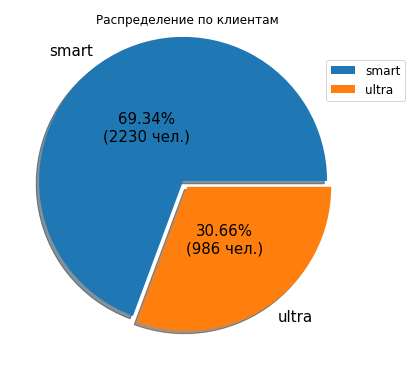

In [42]:
def func_pct(pct):
    value = float(pct/100.*df_all['user_id'].count())
    return "{:.2f}%\n({:.0f} чел.)".format(pct, value)

explode = (0.05, 0)  # сектор 'ultra' немного выдвинем

axes = df_all.groupby('tariff_name')['user_id'].count().plot(kind='pie', subplots=True, fontsize=15,
                                                                     use_index=False, shadow=True, explode=explode,
                                                                     title = 'Распределение по клиентам', pctdistance=0.45,
                                                                     figsize=(20,5), autopct=lambda pct: func_pct(pct))

plt.tight_layout(pad=0)

for ax in axes:
    ax.legend(['smart', 'ultra'], bbox_to_anchor=(0.87,0.87), prop={'size':12})
    ax.set_ylabel('')

Посмотрим на частоту использования (проговоренные минуты, отправленные СМС и используемый интернет-трафик) по каждому из тарифов

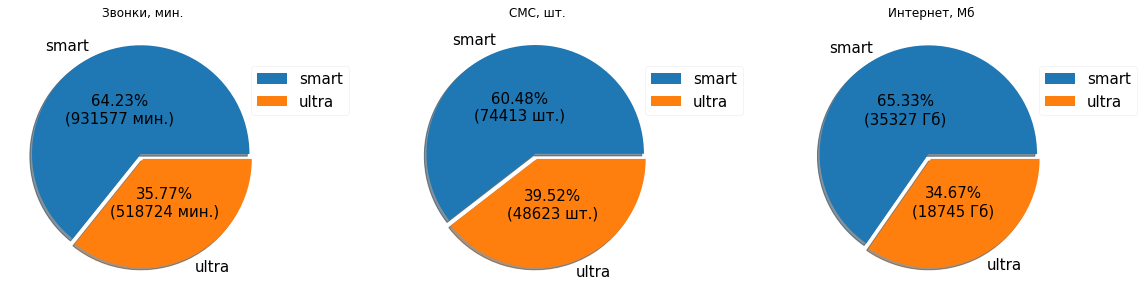

In [43]:
columns_to_plot = ['sum_minutes', 'count_mess', 'mb_used']

calls_sum = df_all['sum_minutes'].sum()
sms_sum = df_all['count_mess'].sum()
internet_sum = df_all['mb_used'].sum()

def func_pct(pct):
    if pct > 65 or pct < 35:
        sum_of_data = internet_sum
        value = float(pct/100.*sum_of_data/1024)
        metric = 'Гб'
    elif pct > 64 or pct < 36:
        sum_of_data = calls_sum
        value = float(pct/100.*sum_of_data)
        metric = 'мин.'
    else:
        sum_of_data = sms_sum
        value = float(pct/100.*sum_of_data)
        metric = 'шт.'
    return "{:.2f}%\n({:.0f} {})".format(pct, value, metric)

explode = (0.05, 0)  # сектор 'ultra' немного выдвинем

axes = df_all.groupby('tariff_name')[columns_to_plot].sum().plot(kind='pie', subplots=True, fontsize=15,
                                                                       use_index=False, shadow=True, explode=explode,
                                                                       title = ['Звонки, мин.', 'СМС, шт.', 'Интернет, Мб'],
                                                                       pctdistance=0.45, autopct=lambda pct: func_pct(pct),
                                                                       figsize=(20,5))

for ax in axes:
    ax.legend(['smart', 'ultra'], framealpha=0.2, bbox_to_anchor=(0.87,0.87), prop={'size':15})
    ax.set_ylabel('')

Кол-во пользователей, подключенных к тарифу smart больше чем ктарифу ultra. Соответственно и использование минут, смс и интернета, на тарифе smart больше.

**3.2.Опишем поведение клиентов оператора, исходя из выборки:**

Для удобства создадим 2 датафрейма (по тарифам smart  ultra) из общего датафрейма df_all


In [44]:
smart = df_all.query('tariff_name == "smart"')
smart_sum = smart.pivot_table(index=['month'], values=('sum_minutes', 'mb_used', 'count_mess'), aggfunc='sum')
        
ultra = df_all.query('tariff_name == "ultra"')
ultra_sum = ultra.pivot_table(index=['month'], values=('sum_minutes', 'mb_used', 'count_mess'), aggfunc='sum')

    3.2.1. Сколько минут разговора требуется пользователям каждого тарифа в месяц?

In [45]:
smart_ultra_minutes = pd.merge(smart_sum[['sum_minutes']], ultra_sum[['sum_minutes']], on = 'month', how = 'outer')

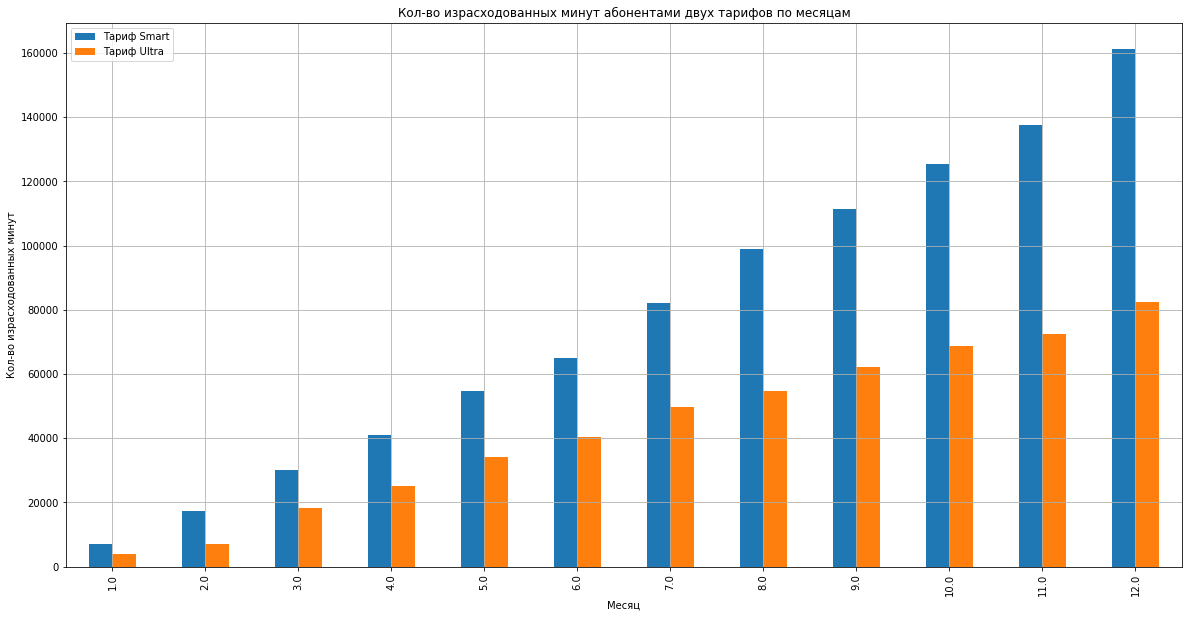

In [46]:
smart_ultra_minutes.plot(kind='bar', title=('Кол-во израсходованных минут абонентами двух тарифов по месяцам'),
                         figsize=(20,10), grid=True)
plt.xlabel('Месяц')
plt.ylabel('Кол-во израсходованных минут')
plt.legend(['Тариф Smart', 'Тариф Ultra'])
plt.show()

Использование минут на тарифе smart больше, чем на ultra. При чем smart лидирует в каждом месяце.

    3.2.2. Сколько сообщений требуется пользователям каждого тарифа в месяц?

In [47]:
smart_ultra_mess = pd.merge(smart_sum[['count_mess']], ultra_sum[['count_mess']], on = 'month', how = 'outer')

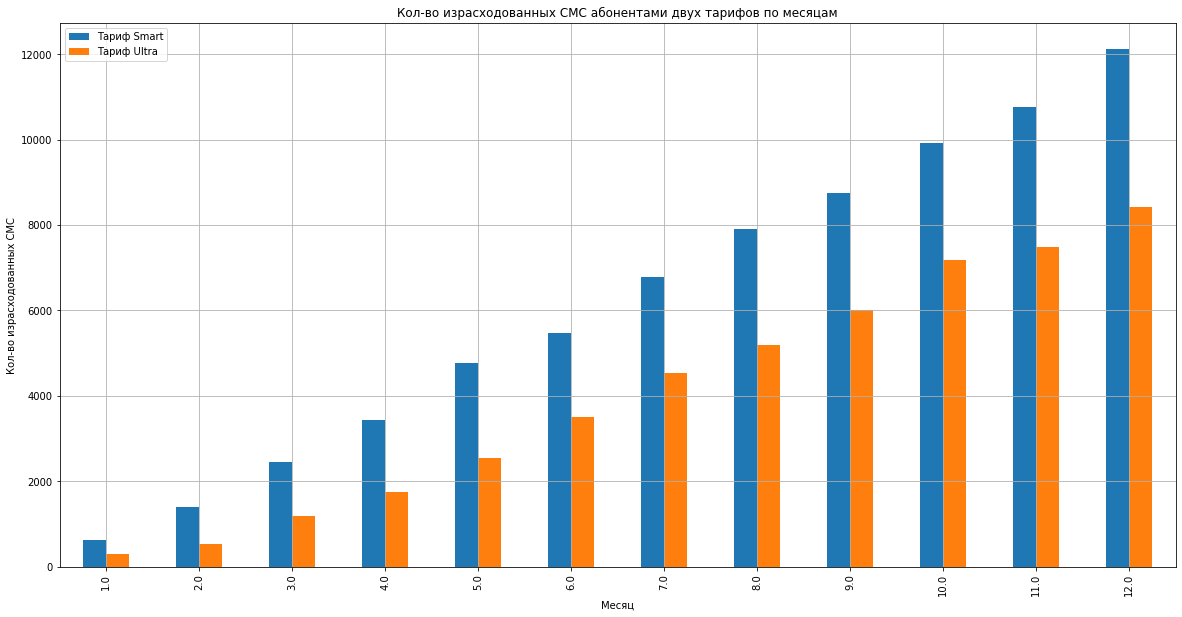

In [48]:
smart_ultra_mess.plot(kind='bar', title=('Кол-во израсходованных СМС абонентами двух тарифов по месяцам'),
                         figsize=(20,10), grid=True)
plt.xlabel('Месяц')
plt.ylabel('Кол-во израсходованных СМС')
plt.legend(['Тариф Smart', 'Тариф Ultra'])
plt.show()

Использование СМС на тарифе smart больше, чем на ultra. При чем smart лидирует в каждом месяце.

    3.2.3 Какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 

In [49]:
smart_ultra_int = pd.merge(smart_sum[['mb_used']], ultra_sum[['mb_used']], on = 'month', how = 'outer')

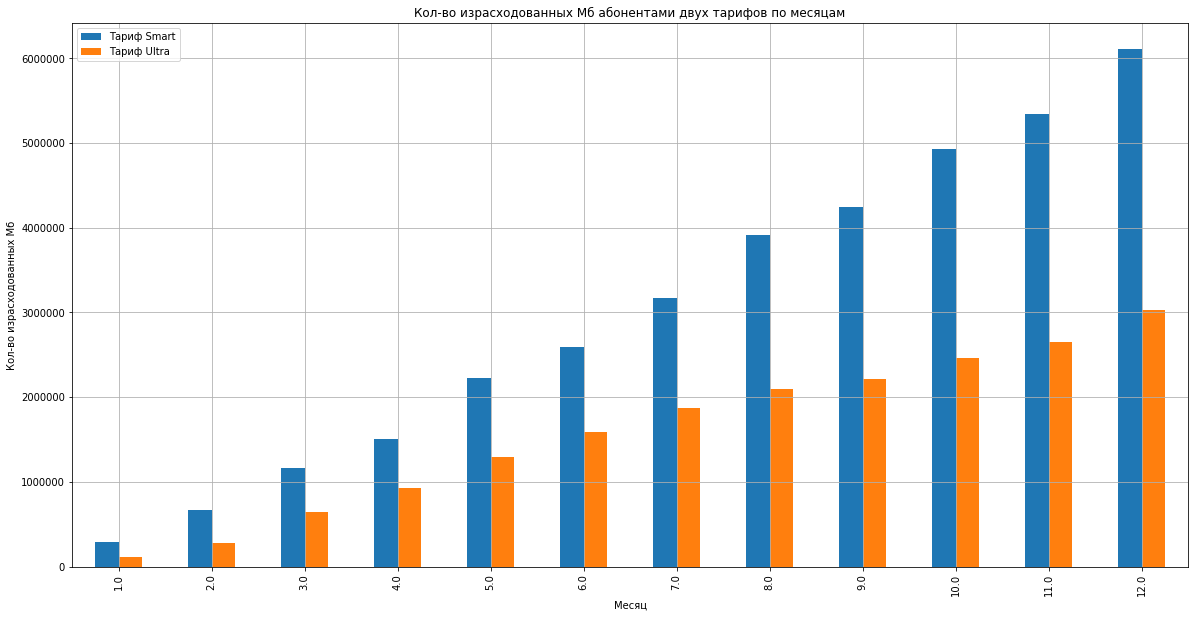

In [50]:
smart_ultra_int.plot(kind='bar', title=('Кол-во израсходованных Мб абонентами двух тарифов по месяцам'),
                         figsize=(20,10), grid=True)
plt.xlabel('Месяц')
plt.ylabel('Кол-во израсходованных Мб')
plt.legend(['Тариф Smart', 'Тариф Ultra'])
plt.show()

Использование интернета на тарифе smart больше, чем на ultra. При чем smart лидирует в каждом месяце.

**3.3. Посчитайте среднее количество, дисперсию и стандартное отклонение.**

In [51]:
smart_3 = smart.pivot_table(index=['month'], values=('sum_minutes', 'mb_used', 'count_mess'), aggfunc=('mean', 'std', 'var'))
          
smart_3

count_mess                              mb_used               \
            mean        std         var          mean          std   
month                                                                
1.0    18.235294  16.197753  262.367201   8524.441176  6451.837940   
2.0    24.086207  21.750809  473.097701  11611.396552  6254.546293   
3.0    31.857143  26.804710  718.492481  15123.857143  5835.460138   
4.0    30.741071  24.538532  602.139559  13479.482143  5705.029114   
5.0    33.773050  27.036845  730.990983  15825.198582  5985.177978   
6.0    33.402439  28.404337  806.806374  15814.768293  5797.966469   
7.0    33.751244  28.282288  799.887811  15763.512438  5904.328642   
8.0    33.638298  28.952677  838.257501  16632.174468  5600.314007   
9.0    33.638462  28.117927  790.617820  16324.526923  5202.129029   
10.0   33.765306  28.567673  816.111966  16778.564626  5866.609964   
11.0   34.075949  28.389031  805.937071  16917.531646  5346.823769   
12.0   35.887574  30.594298  936.011062  18083.174556  5658.766341   

                    sum_minutes                            
                var        mean         std           var  
month                                                      
1.0    4.162621e+07  203.852941  154.231454  23787.341355  
2.0    3.911935e+07  298.689655  190.820041  36412.287961  
3.0    3.405260e+07  390.051948  191.893604  36823.155161  
4.0    3.254736e+07  367.133929  186.489161  34778.207127  
5.0    3.582236e+07  387.361702  186.601343  34820.061094  
6.0    3.361642e+07  395.640244  175.336587  30742.918861  
7.0    3.486110e+07  408.353234  179.583601  32250.269602  
8.0    3.136352e+07  421.468085  186.530382  34793.583379  
9.0    2.706215e+07  428.611538  183.126576  33535.342723  
10.0   3.441711e+07  426.136054  188.128510  35392.336375  
11.0   2.858852e+07  435.265823  177.778618  31605.237050  
12.0   3.202164e+07  477.144970  200.644953  40258.397319

In [52]:
ultra_3 = ultra.pivot_table(index=['month'], values=('sum_minutes', 'mb_used', 'count_mess'), aggfunc=('mean', 'std', 'var'))
        
ultra_3

count_mess                               mb_used                \
            mean        std          var          mean           std   
month                                                                  
1.0    33.777778  30.670742   940.694444  13153.555556   6872.147046   
2.0    21.958333  26.773574   716.824275  11786.958333  10654.343346   
3.0    32.297297  41.621886  1732.381381  17551.972973  10961.936316   
4.0    31.563636  37.513831  1407.287542  16843.800000   9727.483304   
5.0    37.850746  40.306874  1624.644052  19381.194030  10055.634106   
6.0    41.726190  44.567899  1986.297619  18942.238095   9301.745817   
7.0    49.846154  48.703621  2372.042735  20514.648352  10073.606689   
8.0    48.439252  46.601923  2171.739199  19594.065421  10485.992263   
9.0    52.286957  46.398874  2152.855530  19222.208696   9494.672266   
10.0   58.430894  51.934398  2697.181661  20063.869919   9811.814618   
11.0   55.791045  49.768951  2476.948491  19805.313433   9916.674617   
12.0   60.178571  51.854843  2688.924717  21657.778571  10513.211924   

                    sum_minutes                             
                var        mean         std            var  
month                                                       
1.0    4.722641e+07  428.111111  269.757968   72769.361111  
2.0    1.135150e+08  297.125000  296.512528   87919.679348  
3.0    1.201640e+08  489.648649  333.743765  111384.900901  
4.0    9.462393e+07  458.018182  267.682405   71653.870034  
5.0    1.011158e+08  510.328358  289.603511   83870.193578  
6.0    8.652248e+07  479.702381  302.549081   91535.946500  
7.0    1.014776e+08  545.791209  307.119322   94322.278144  
8.0    1.099560e+08  510.775701  312.980026   97956.496385  
9.0    9.014880e+07  539.443478  325.141162  105716.775286  
10.0   9.627171e+07  558.081301  326.289110  106464.583500  
11.0   9.834044e+07  541.380597  310.757232   96570.057064  
12.0   1.105276e+08  588.571429  344.880777  118942.750257

Минуты разговора, число сообщений и объем потраченного интернет-трафика по тарифу «Ультра» имеет большую дисперсию по сравнению с тарифом «Смарт».

In [53]:
df_all_3 = (df_all.pivot_table(index=['month'], values=('sum_minutes', 'mb_used', 'count_mess')
                               , aggfunc=('mean', 'std', 'var'))
          )
df_all_3

count_mess                               mb_used               \
            mean        std          var          mean          std   
month                                                                 
1.0    21.488372  20.645964   426.255814   9493.325581  6732.948253   
2.0    23.463415  23.182153   537.412225  11662.780488  7730.947806   
3.0    32.000000  32.174304  1035.185841  15911.929825  7904.991639   
4.0    31.011976  29.335613   860.578169  14587.491018  7420.238800   
5.0    35.086538  31.875395  1016.040784  16970.639423  7696.881162   
6.0    36.221774  34.863575  1215.468836  16874.072581  7311.508214   
7.0    38.767123  36.594188  1339.134586  17244.174658  7759.087193   
8.0    38.269006  36.021468  1297.546192  17558.847953  7589.042961   
9.0    39.357333  35.747335  1277.871971  17213.149333  6928.887253   
10.0   41.040767  38.634639  1492.635353  17747.611511  7397.593304   
11.0   40.542222  37.389055  1397.941420  17777.448889  7136.806815   
12.0   43.002092  39.589323  1567.314461  19130.129707  7581.780475   

                    sum_minutes                            
                var        mean         std           var  
month                                                      
1.0    4.533259e+07  250.790698  202.662464  41072.074197  
2.0    5.976755e+07  298.231707  224.919591  50588.822192  
3.0    6.248889e+07  422.377193  249.890539  62445.281245  
4.0    5.505994e+07  397.065868  219.999566  48399.808888  
5.0    5.924198e+07  426.971154  231.535536  53608.704478  
6.0    5.345815e+07  424.112903  229.425518  52636.068173  
7.0    6.020343e+07  451.184932  235.378514  55403.044721  
8.0    5.759357e+07  449.409357  236.739204  56045.450704  
9.0    4.800948e+07  462.600000  240.969455  58066.278075  
10.0   5.472439e+07  465.055156  244.498996  59779.758970  
11.0   5.093401e+07  466.864444  230.517191  53138.175348  
12.0   5.748340e+07  509.780335  256.280605  65679.748292

In [54]:
df_all.name = 'df_all'
smart.name = 'smart'
ultra.name = 'ultra'

df_ar = [df_all, smart, ultra]
stp3_ar = ['sum_minutes', 'mb_used', 'count_mess']
fnct_ar = [np.std, np.var, np.mean]

for a in range (len(stp3_ar)):
    print(f"{stp3_ar[a]}:")
    for x in range(len(fnct_ar)):
        print(f"\t{str(fnct_ar[x]).split()[1]}:")
        for i in range(len(df_ar)):
            print(f"\t\t {df_ar[i].name}: {fnct_ar[x](df_ar[i][stp3_ar[a]])}")

sum_minutes:
	std:
		 df_all: 242.05866960258336
		 smart: 190.4340414765959
		 ultra: 317.7263071155912
	var:
		 df_all: 58592.39952977262
		 smart: 36265.12415310985
		 ultra: 100950.00623331098
	mean:
		 df_all: 450.9642412935323
		 smart: 417.747533632287
		 ultra: 526.0892494929006
mb_used:
	std:
		 df_all: 7586.892018556221
		 smart: 5884.979681043659
		 ultra: 10105.127196148806
	var:
		 df_all: 57560930.50123209
		 smart: 34632985.84629673
		 ultra: 102113595.65034623
	mean:
		 df_all: 17216.87157960199
		 smart: 16221.910762331838
		 ultra: 19467.137931034482
count_mess:
	std:
		 df_all: 36.14406299905219
		 smart: 28.224065559229217
		 ultra: 47.781791061922284
	var:
		 df_all: 1306.3932900794534
		 smart: 796.5978766916688
		 ultra: 2283.0995570851965
	mean:
		 df_all: 38.257462686567166
		 smart: 33.36905829596412
		 ultra: 49.31338742393509


**3.4. Постройте гистограммы. Опишите распределения.**

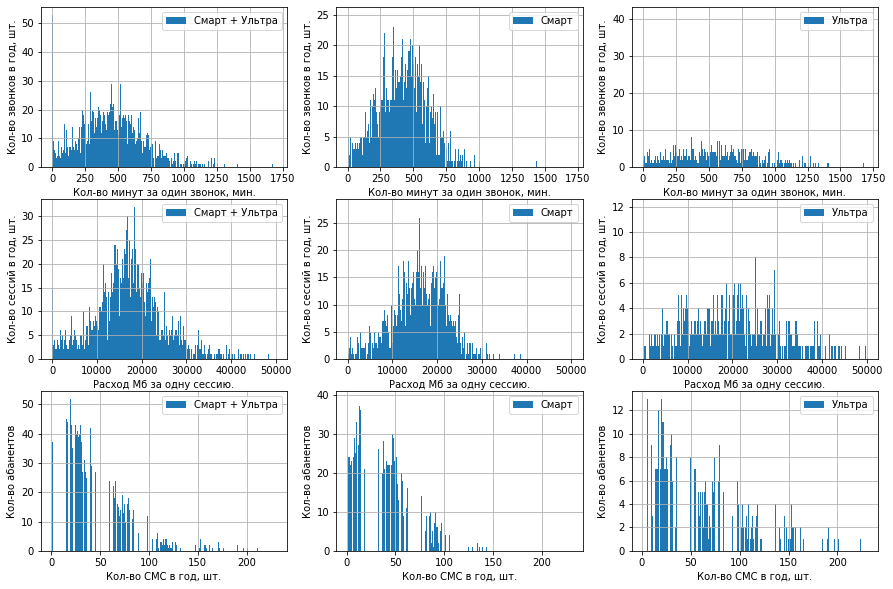

In [55]:
dfs = [df_all, smart, ultra]
columns = ['sum_minutes', 'mb_used', 'count_mess']
ranges = [(0, 1700), (0, 50000), (1, 230)]
names = [['Кол-во минут, общие данные', 'Кол-во минут, тариф Смарт', 'Кол-во минут, тариф Ультра'],
         ['Расход Мб, общие данные', 'Расход Мб, тариф Смарт', 'Расход Мб, тариф Ультра'],
         ['Кол-во СМС, общие данные', 'Кол-во СМС, тариф Смарт', 'Кол-во СМС, тариф Ультра']
        ]
labels=['Смарт + Ультра', 'Смарт', 'Ультра']
names_x = ['Кол-во минут за один звонок, мин.', 'Расход Мб за одну сессию.', 'Кол-во СМС в год, шт.']
names_y = ['Кол-во звонков в год, шт.', 'Кол-во сессий в год, шт.', 'Кол-во абанентов']
bins = [500, 500, 500]

f, axs = plt.subplots(3, 3, figsize = (15,10))

for j, a in enumerate(range(len(dfs))):
    for i in range(len(columns)):
        axs[i][j].hist(dfs[a][columns[i]], range = ranges[i], bins=bins[i], label=labels[j])
        #axs[i][j].set_title(names[i][j])
        axs[i][j].set_xlabel(names_x[i])
        axs[i][j].set_ylabel(names_y[i])
        axs[i][j].grid()
        axs[i][j].legend()

plt.show()

Из гистограмм видно что:
 * Тариф Смарт
    * Многие пользователи привышают лимит минут (500 мин).
    * Примерно половина превышает лимит использования интернет трафику 15 Гб (15360 Мб).
    * Есть абоненты, которые дозаказывают пакет СМС. (лимит 50 СМС)
 * Тариф Ультра
    * Нет абонентов, превышающих лимт использования минут (3000 мин)
    * Немного абанентов, которые превышают лимит использования интернет трафика 30 Гб (30720 Мб).
    * Нет абонентов, превышающих лимт использования СМС (1000 СМС)

Посмотрим на оплаты тарифов абонентами по месяцам

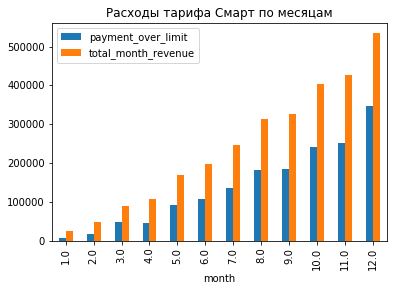

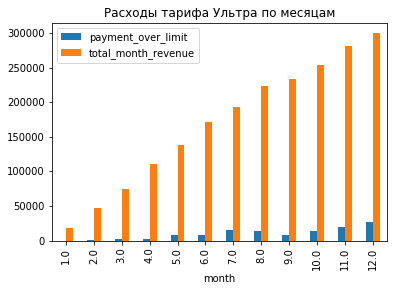

In [58]:
(smart.pivot_table(index=['month'], values=('payment_over_limit', 'total_month_revenue'), aggfunc=('sum'))
      .plot(kind='bar', title='Расходы тарифа Смарт по месяцам')
)
plt.xlabel='Месяц'
plt.ylabel='Руб.'
(ultra.pivot_table(index=['month'], values=('payment_over_limit', 'total_month_revenue'), aggfunc=('sum'))
      .plot(kind='bar', title='Расходы тарифа Ультра по месяцам')
)
plt.xlabel='Месяц'
plt.ylabel='Руб.'
plt.show()

На тарифе Смарт абоненты, каждый месяц, докупают услуги связи. К декабрю суммарная переплата выше 300000 руб.
На тарифе Ультра абоненты почти не докупают услуги связи. Им хватает лимитов, которые предусмотрены тарифом.

# Шаг 4. Проверьте гипотезы
средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;
Пороговое значение alpha задайте самостоятельно.
Поясните:
как вы формулировали нулевую и альтернативную гипотезы;
какой критерий использовали для проверки гипотез и почему.

**4.1. Проверим гипотезу - Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.**

Нулевая гипотеза - средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей тарифа «Смарт». 

Альтернативной гипотезой будет наша гипотеза "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается".

Использую метод scipy.stats.ttest_ind (array1, array2, equal_var = False). False, потому что дисперсии наших выборок отличаются.

Критический уровень значимости задам 0.05.

In [ ]:
alpha = 0.05
results = st.ttest_ind(smart['total_month_revenue'], ultra['total_month_revenue'], equal_var = False)
print('P-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

In [ ]:
smart['total_month_revenue'].describe().T

In [ ]:
ultra['total_month_revenue'].describe().T

***Вывод по гипотезе 1:***

Нулевой гипотезой была гипотеза о равенстве средних наших выборок и очень маленькое p-value говорит нам о том, вероятность случайного совпадения средних наших выборок ничтожно мало. Нулевая гипотеза отвергается!

А значит сформулированная нами альтернативная гипотеза о том, что средние наших выборок отличаются, не отвергается!

**4.2. Проверим гипотезу - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.**

Нулевая гипотеза - средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

Альтернативная гипотеза - средняя выручка пользователей из Москвы отличается от средней выручке пользователей из других регионов.

Для проверки гипотезы создадим две соответствующие таблицы moscow и other. В обеих таблицах будут пользователи обоих тарифов.

Критический уровень значимости поставим 0.05.

Воспользуюсь методом scipy.stats.ttest_ind(array1, array2, equal_var = False). Equal_var будет False, так как мне кажется, что если считать дисперсию каждой выборки отдельно, то точность теста будет выше.

In [ ]:
moscow = df_all[df_all['city'] == 'Москва']
other = df_all[df_all['city'] != 'Москва']

In [ ]:
alpha = 0.05
results = st.ttest_ind(moscow['total_month_revenue'], other['total_month_revenue'], equal_var = False)
print('P-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

In [ ]:
moscow['total_month_revenue'].describe().T

In [ ]:
other['total_month_revenue'].describe().T

***Вывод по гипотезе 2:***

Полученное нами p-value равно 0.53, а значит есть большая вероятность того, что отличие средних значений наших выборок случайно и мы не можем отвергнуть нулевую гипотезу, которая говорит нам о равенстве средних значений.

Значит, нашу альтернативную гипотезу о различии средних мы отвергаем.

# 5. Общий вывод


По результатам статистического анализа доходы от тарифа «Ультра» больше, чем от тарифа «Смарт»: в среднем «Мегалайн» от одного пользователя в месяц получает 2070 рублей и 1294 рубля соответственно.

Особенности использования тарифов заключаются в следующем:

Пользователям тарифа «Смарт» не хватает услуг в рамках тарифного пакета: кроме абонентской платы пользователи в среднем доплачивают еще 744 рубля ежемесячно.


In [ ]:
smart_pivot = (smart.pivot_table(index=['month'], values=('payment_over_limit', 'total_month_revenue'), aggfunc=('sum'))
                 
)
smart_pivot['Процент переплат от абонентской платы, %'] = ((smart_pivot['payment_over_limit'] / 
                                                      smart.groupby('month')['rub_monthly_fee'].sum()*100).astype(int)
                                                    )

smart_pivot.rename(columns={'payment_over_limit': 'Расходы на услуги связи не включающие абонентскую плату, руб.'
                         , 'total_month_revenue': 'Расходы на услуги связи включающие абонентскую плату, руб.'})

Плата за дополнительные услуги, к концу года доходит до 187% от абонентской платы.


Пользователи тарифа «Ультра», напротив, не используют тарифный пакет в полном объеме.

Средние доходы от пользователей в Москве не отличаются от доходов в других населенных пунктах: 1550 руб. в Москве против 1528 руб в других населенных пунктах.